In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install librosa

In [3]:
import librosa
from librosa import display

data, sampling_rate = librosa.load('/content/drive/My Drive/Audio_Speech_Actors_01-24/Actor_01/03-01-01-01-01-01-01.wav')

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['display']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


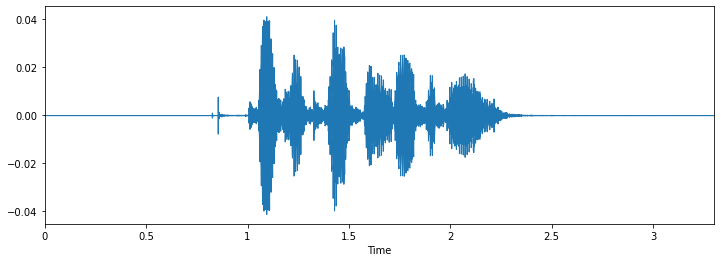

In [4]:

% pylab inline
import os
import pandas as pd
import glob 

plt.figure(figsize=(12, 4))
librosa.display.waveplot(data, sr=sampling_rate)

Feature extraction using d tree

In [5]:
import time

#path = '/content/drive/My Drive/Audio_Speech_Actors_01-24/Actor_01/'
#path = '/content/drive/My Drive/Speech/AudioFiles/Actor_01/'
path = '/content/drive/My Drive/Speech/'
lst = []

start_time = time.time()

for subdir, dirs, files in os.walk(path):
  for file in files:
      try:
        #Load librosa array, obtain mfcss, store the file and the mcss information in a new array
        X, sample_rate = librosa.load(os.path.join(subdir,file), res_type='kaiser_fast')
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
        # The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
        # This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
        file = int(file[7:8]) - 1 
        #print(file)
        arr = mfccs, file
        #print(arr)
        lst.append(arr)
        #print(lst)
      # If the file is not valid, skip it
      except ValueError:
        continue

print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))

--- Data loaded. Loading time: 425.0565321445465 seconds ---


In [6]:

X, y = zip(*lst)

In [7]:
import numpy as np
X = np.asarray(X)
y = np.asarray(y)


X.shape, y.shape

((1440, 40), (1440,))

In [8]:
import joblib

X_name = 'X.joblib'
y_name = 'y.joblib'
save_dir = '/content/drive/My Drive/Model/'

savedX = joblib.dump(X, os.path.join(save_dir, X_name))
savedy = joblib.dump(y, os.path.join(save_dir, y_name))

In [9]:
X = joblib.load('/content/drive/My Drive/Model/X.joblib')
y = joblib.load('/content/drive/My Drive/Model/y.joblib')

In [10]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
dtree = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

TypeError: ignored

In [ ]:
dtree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='random')

In [ ]:
predictions = dtree.predict(X_test)

In [ ]:

from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions))

NameError: ignored

Feature extraction using Forest

In [11]:
from sklearn.ensemble import RandomForestClassifier

In [12]:
# gini criterion
rforest = RandomForestClassifier(criterion="entropy", max_depth=10, max_features="log2", 
                                 max_leaf_nodes = 100, min_samples_leaf = 3, min_samples_split = 10, 
                                 n_estimators= 22000, random_state= 40)

In [13]:
rforest.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=10, max_features='log2',
                       max_leaf_nodes=100, min_samples_leaf=3,
                       min_samples_split=10, n_estimators=22000,
                       random_state=40)

In [14]:
predictions = rforest.predict(X_test)

In [15]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        18
           1       0.45      0.93      0.61        41
           2       0.68      0.38      0.49        45
           3       0.38      0.35      0.36        34
           4       0.69      0.71      0.70        34
           5       0.59      0.61      0.60        38
           6       0.47      0.53      0.50        34
           7       0.63      0.50      0.56        44

    accuracy                           0.53       288
   macro avg       0.49      0.50      0.48       288
weighted avg       0.53      0.53      0.51       288



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [18]:
x_traincnn.shape, x_testcnn.shape
#print(X_train.shape[1], X_train.shape[0])

((1152, 40, 1), (288, 40, 1))

In [46]:
!pip install keras
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, LSTM
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

model = Sequential()
model.add(Conv1D(128, 5,padding='same',
                 input_shape=(40,1)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same', input_shape=(40,1)))
model.add(MaxPooling1D(pool_size=(5)))
model.add(Conv1D(128, 5,padding='same', input_shape=(40,1)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(8))
model.add(Activation('softmax'))
opt = tf.keras.optimizers.RMSprop(learning_rate=0.00005, rho=0.9, epsilon=None, decay=0.0)

In [47]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 40, 128)           768       
                                                                 
 activation_3 (Activation)   (None, 40, 128)           0         
                                                                 
 dropout_2 (Dropout)         (None, 40, 128)           0         
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 5, 128)           0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 5, 128)            82048     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 1, 128)           0         
 1D)                                                  

In [48]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [52]:

cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=1300, validation_data=(x_testcnn, y_test))
#History = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=1150, epochs=30)

#cnnhistory=model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1000, batch_size=16) 

Epoch 1/1300
72/72 [==============================] - 1s 10ms/step - loss: 0.5999 - accuracy: 0.7856 - val_loss: 1.2773 - val_accuracy: 0.5903
Epoch 2/1300
72/72 [==============================] - 1s 9ms/step - loss: 0.5681 - accuracy: 0.7865 - val_loss: 1.2853 - val_accuracy: 0.5799
Epoch 3/1300
72/72 [==============================] - 1s 9ms/step - loss: 0.5833 - accuracy: 0.7969 - val_loss: 1.3015 - val_accuracy: 0.5660
Epoch 4/1300
72/72 [==============================] - 1s 9ms/step - loss: 0.5621 - accuracy: 0.8003 - val_loss: 1.2681 - val_accuracy: 0.6042
Epoch 5/1300
72/72 [==============================] - 1s 9ms/step - loss: 0.5766 - accuracy: 0.7891 - val_loss: 1.2932 - val_accuracy: 0.5972
Epoch 6/1300
72/72 [==============================] - 1s 10ms/step - loss: 0.5629 - accuracy: 0.8064 - val_loss: 1.3220 - val_accuracy: 0.5729
Epoch 7/1300
72/72 [==============================] - 1s 9ms/step - loss: 0.5678 - accuracy: 0.7977 - val_loss: 1.3111 - val_accuracy: 0.5694
Epoc

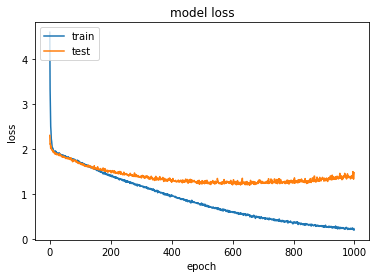

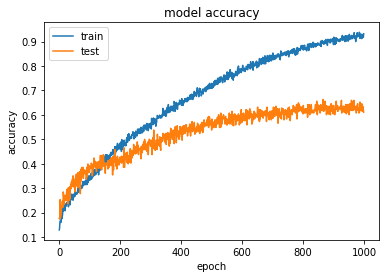

In [23]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [25]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = '/content/drive/My Drive/Save_model'
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/drive/My Drive/Save_model/Emotion_Voice_Detection_Model.h5 


In [29]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [2]:
import keras
loaded_model = keras.models.load_model('/content/drive/My Drive/Save_model/Emotion_Voice_Detection_Model.h5')
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 40, 128)           768       
                                                                 
 activation (Activation)     (None, 40, 128)           0         
                                                                 
 dropout (Dropout)           (None, 40, 128)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 5, 128)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 5, 128)            82048     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 128)           0         
 1D)                                                    